Importing the dataset and making the train test validation splits for the voronoi images

In [8]:
import os
import torch
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# === Reproducibility
SEED = 42
torch.manual_seed(SEED)

# === Paths
base_dir = Path().resolve()
image_dir = base_dir /"datasets/binary_dataset/binary"

# === Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust as needed for your CNN
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Assumes grayscale or uniform RGB
])

# === Load Dataset
dataset = datasets.ImageFolder(root=image_dir, transform=transform)

# === Confirm class mapping
print("Classes:", dataset.classes)  # Should print ['0', '1']
print("Total images:", len(dataset))

# === Split sizes
total = len(dataset)
train_size = int(0.75 * total)
val_size = int(0.1 * total)
test_size = total - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# === DataLoaders (adjust batch_size)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Classes: ['immunogenic', 'non_immunogenic']
Total images: 1039
Train: 779, Val: 103, Test: 157


Importing the dataset and making the train test validation splits for the graphs

In [11]:
import random
import torch
from pathlib import Path
from torch_geometric.data import Data
from torch.serialization import add_safe_globals

# === Allow PyTorch Geometric types for unpickling ===
import torch_geometric
add_safe_globals([
    torch_geometric.data.Data,
    torch_geometric.data.Batch,  # Optional: include if you use batched data
])

# === Set seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# === Base directories
base_dir = Path().resolve()
dataset_dir = base_dir / "datasets"
input_dir_1 = dataset_dir / "original_datasets/tumor_antigens_immunogenic" / "graphs"
input_dir_0 = dataset_dir / "original_datasets/tumor_antigens_non-immunogenic" / "graphs"
output_dir = dataset_dir / "binary_dataset" / "graph_datasets"
output_dir.mkdir(parents=True, exist_ok=True)

# === Load graph file paths and assign labels
files_1 = [(f, 1) for f in input_dir_1.glob("*.pth")]
files_0 = [(f, 0) for f in input_dir_0.glob("*.pth")]

data = files_1 + files_0
random.shuffle(data)

# === Define split sizes
total = len(data)
train_size = int(0.75 * total)
val_size = int(0.05 * total)
test_size = total - train_size - val_size

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# === Helper to embed label in Data object and save
def save_dataset(data_split, filename):
    dataset = []
    label_counts = {0: 0, 1: 0}

    for file_path, label in data_split:
        g = torch.load(file_path, weights_only=False)
        g.y = torch.tensor([label], dtype=torch.float)
        dataset.append(g)
        label_counts[label] += 1

    torch.save(dataset, output_dir / filename)
    return label_counts

# === Save each split and report counts
train_counts = save_dataset(train_data, "train_set.pth")
val_counts = save_dataset(val_data, "val_set.pth")
test_counts = save_dataset(test_data, "test_set.pth")

print(f"Training: {len(train_data)} (Class 0: {train_counts[0]}, Class 1: {train_counts[1]})")
print(f"Validation: {len(val_data)} (Class 0: {val_counts[0]}, Class 1: {val_counts[1]})")
print(f"Test: {len(test_data)} (Class 0: {test_counts[0]}, Class 1: {test_counts[1]})")
print(f"Datasets saved in: {output_dir}")


Training: 793 (Class 0: 392, Class 1: 401)
Validation: 52 (Class 0: 26, Class 1: 26)
Test: 213 (Class 0: 105, Class 1: 108)
Datasets saved in: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/datasets/binary_dataset/graph_datasets


Testing the benchmark model used in the paper of ibionet where they used the ResNet18 to trained their model but with feature extraction (only the last layer is being retrained the rest of the model remains frozen and does transfer learning). This is the method they used in their paper.

Using device: mps


/Users/marcobenavides/miniconda3/envs/ML4FG/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcobenavides/miniconda3/envs/ML4FG/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Loss: 17.8261, Train Acc: 0.5096, Val Acc: 0.5686, Val Loss: 0.6504
Epoch 2/10 - Loss: 15.9368, Train Acc: 0.6624, Val Acc: 0.7647, Val Loss: 0.5773
Epoch 3/10 - Loss: 14.7216, Train Acc: 0.7176, Val Acc: 0.7451, Val Loss: 0.5480
Epoch 4/10 - Loss: 14.0238, Train Acc: 0.7317, Val Acc: 0.7451, Val Loss: 0.5280
Epoch 5/10 - Loss: 13.6622, Train Acc: 0.7433, Val Acc: 0.7647, Val Loss: 0.5169
Epoch 6/10 - Loss: 13.2459, Train Acc: 0.7548, Val Acc: 0.7647, Val Loss: 0.4944
Epoch 7/10 - Loss: 12.9531, Train Acc: 0.7535, Val Acc: 0.7647, Val Loss: 0.4992
Epoch 8/10 - Loss: 12.7384, Train Acc: 0.7677, Val Acc: 0.7647, Val Loss: 0.4778
Epoch 9/10 - Loss: 12.6315, Train Acc: 0.7728, Val Acc: 0.7451, Val Loss: 0.4726
Epoch 10/10 - Loss: 12.4460, Train Acc: 0.7715, Val Acc: 0.7647, Val Loss: 0.4968
Best threshold found: 0.4463 (AUC: 0.8412)


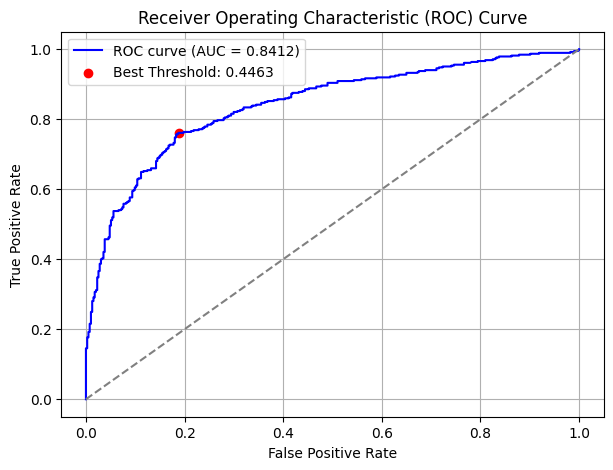

Test Accuracy: 0.7177 (Using Threshold: 0.4463)
Precision: 0.7290, Recall: 0.7222, F1-Score: 0.7256


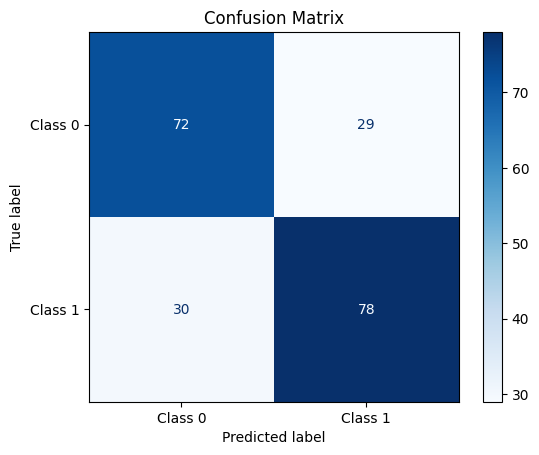

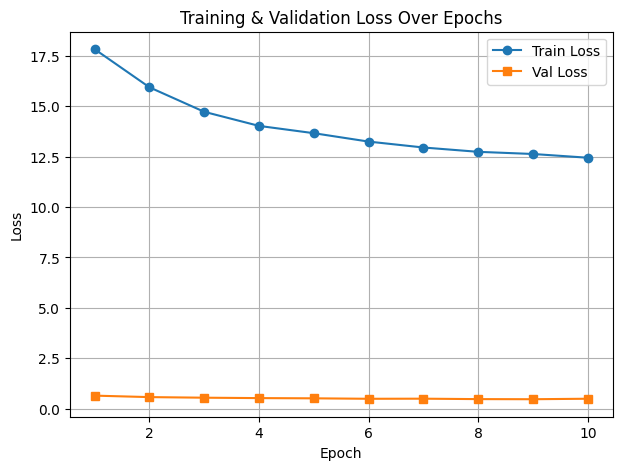

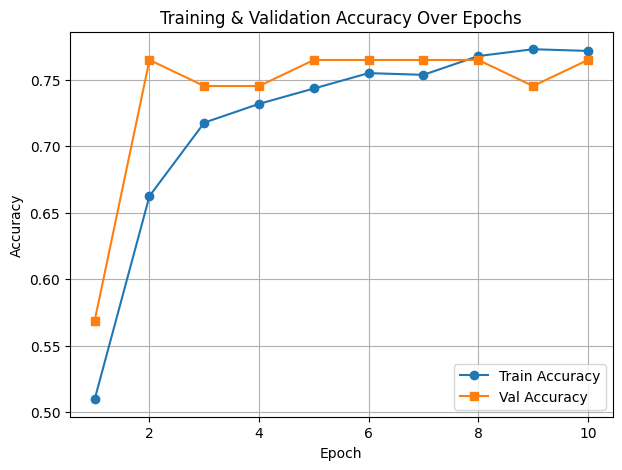

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from architectures.benchmark_ResNet18 import make_model  # Import ResNet18 model
from torch.utils.data.dataset import Subset
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load dataset splits safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("datasets/binary_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("datasets/binary_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("datasets/binary_dataset/image_datasets/test_set.pth", weights_only=False)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Set device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load ResNet18 model with feature extraction
model = make_model("resnet18", feature_extracting=True, use_pretrained=True).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

# Track losses and accuracy for plots
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        
        # Store results for plotting
        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total, running_loss / len(val_loader)

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Function to find the best threshold using AUC-ROC
def find_best_threshold(model, train_loader):
    """Find the best threshold using training data only (no validation)."""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = labels.cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Use Youden’s J statistic to find the best threshold
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]

    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    # Plot ROC Curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

# Find best threshold from training data
best_threshold = find_best_threshold(model, train_loader)

# Test function using best threshold
def test_model(model, test_loader, threshold):
    """Evaluate the model on test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f} (Using Threshold: {threshold:.4f})")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on test set using best threshold
test_model(model, test_loader, best_threshold)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


Testing the benchmark model used in the paper but increasing the number of epochs from 10 to 20 of ibionet where they used the ResNet18 to trained their model withouth feature extraction (all model is being retrained)

Using device: mps


/Users/marcobenavides/miniconda3/envs/ML4FG/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcobenavides/miniconda3/envs/ML4FG/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 - Loss: 13.6214, Train Acc: 0.7330, Val Acc: 0.7647, Val Loss: 0.4929
Epoch 2/30 - Loss: 12.1730, Train Acc: 0.7677, Val Acc: 0.8039, Val Loss: 0.5344
Epoch 3/30 - Loss: 12.1975, Train Acc: 0.7972, Val Acc: 0.6863, Val Loss: 0.6589
Epoch 4/30 - Loss: 12.0359, Train Acc: 0.7882, Val Acc: 0.7843, Val Loss: 0.5198
Epoch 5/30 - Loss: 10.5985, Train Acc: 0.8228, Val Acc: 0.7647, Val Loss: 0.4479
Epoch 6/30 - Loss: 9.5687, Train Acc: 0.8344, Val Acc: 0.7647, Val Loss: 0.5405
Epoch 7/30 - Loss: 8.7590, Train Acc: 0.8652, Val Acc: 0.8039, Val Loss: 0.4468
Epoch 8/30 - Loss: 8.2484, Train Acc: 0.8742, Val Acc: 0.6471, Val Loss: 0.9730
Epoch 9/30 - Loss: 11.7516, Train Acc: 0.7946, Val Acc: 0.8235, Val Loss: 0.3948
Epoch 10/30 - Loss: 8.3513, Train Acc: 0.8575, Val Acc: 0.8627, Val Loss: 0.3582
Epoch 11/30 - Loss: 5.9554, Train Acc: 0.9140, Val Acc: 0.8431, Val Loss: 0.4369
Epoch 12/30 - Loss: 4.6322, Train Acc: 0.9281, Val Acc: 0.8824, Val Loss: 0.4604
Epoch 13/30 - Loss: 3.5181, Tra

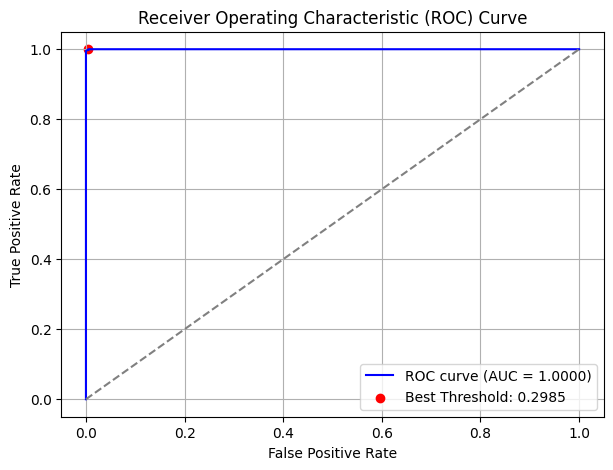

Test Accuracy: 0.7608 (Using Threshold: 0.2985)
Precision: 0.7685, Recall: 0.7685, F1-Score: 0.7685


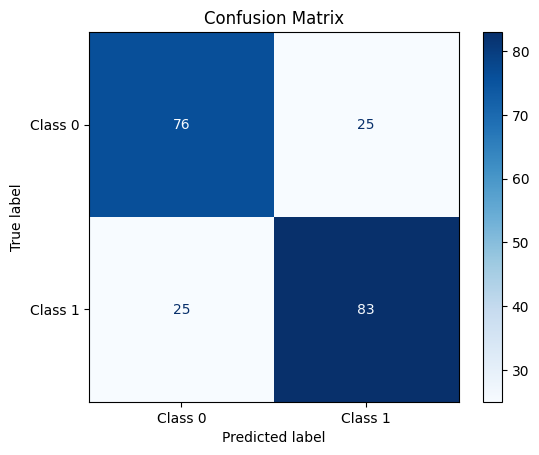

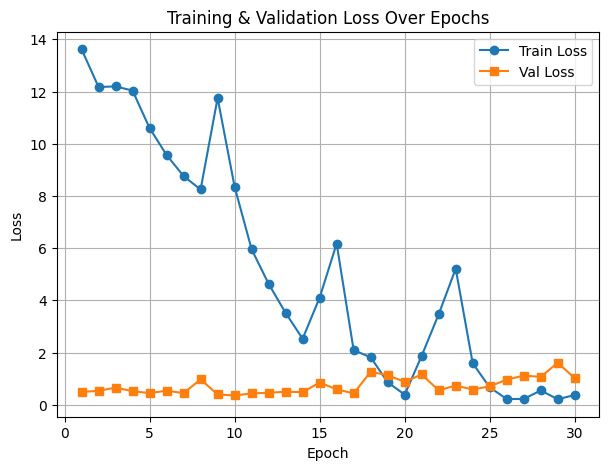

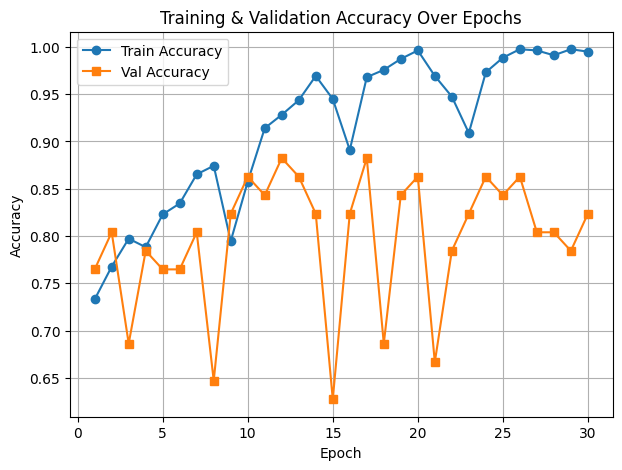

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from architectures.benchmark_ResNet18 import make_model  # Import ResNet18 model
from torch.utils.data.dataset import Subset
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load dataset splits safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("datasets/binary_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("datasets/binary_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("datasets/binary_dataset/image_datasets/test_set.pth", weights_only=False)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Set device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load ResNet18 model
model = make_model("resnet18", feature_extracting=False, use_pretrained=True).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

# Track losses and accuracy for plots
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()  # Still train using 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # Use dynamic threshold for validation
        val_acc, val_loss = validate_model(model, val_loader, criterion, threshold=best_threshold)

        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")




# Validation function
def validate_model(model, val_loader, criterion, threshold=0.5):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total, running_loss / len(val_loader)

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

# Function to find the best threshold using AUC-ROC
def find_best_threshold(model, train_loader):
    """Find the best threshold using training data only (no validation)."""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = labels.cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Use Youden’s J statistic to find the best threshold
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]

    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    # Plot ROC Curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold



# Test function using best threshold
def test_model(model, test_loader, threshold):
    """Evaluate the model on test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f} (Using Threshold: {threshold:.4f})")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on test set using best threshold
test_model(model, test_loader, best_threshold)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


Graph Neural Network for binary prediction (tumor proteins)

/Users/marcobenavides/miniconda3/envs/ML4FG/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Using device: mps
Epoch 1/30 - Loss: 17.0358, Train Acc: 0.5814, Val Acc: 0.6923, Val Loss: 0.6737
Epoch 2/30 - Loss: 16.6840, Train Acc: 0.6590, Val Acc: 0.6923, Val Loss: 0.6445
Epoch 3/30 - Loss: 16.1597, Train Acc: 0.7137, Val Acc: 0.7115, Val Loss: 0.6335
Epoch 4/30 - Loss: 15.6039, Train Acc: 0.7303, Val Acc: 0.7500, Val Loss: 0.6046
Epoch 5/30 - Loss: 14.9875, Train Acc: 0.7341, Val Acc: 0.6923, Val Loss: 0.5940
Epoch 6/30 - Loss: 14.3573, Train Acc: 0.7379, Val Acc: 0.6731, Val Loss: 0.5782
Epoch 7/30 - Loss: 13.9429, Train Acc: 0.7303, Val Acc: 0.6731, Val Loss: 0.5803
Epoch 8/30 - Loss: 13.7896, Train Acc: 0.7328, Val Acc: 0.6731, Val Loss: 0.5670
Epoch 9/30 - Loss: 13.2501, Train Acc: 0.7417, Val Acc: 0.7115, Val Loss: 0.5763
Epoch 10/30 - Loss: 13.1266, Train Acc: 0.7455, Val Acc: 0.7115, Val Loss: 0.6061
Epoch 11/30 - Loss: 13.0109, Train Acc: 0.7506, Val Acc: 0.7115, Val Loss: 0.5632
Epoch 12/30 - Loss: 12.9274, Train Acc: 0.7405, Val Acc: 0.7115, Val Loss: 0.5611
Epoch 1

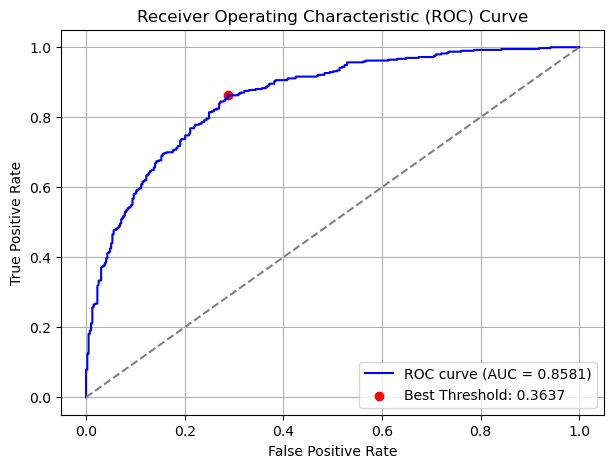

Test Accuracy: 0.7905 (Using Threshold: 0.3637)
Precision: 0.7638, Recall: 0.8739, F1-Score: 0.8151


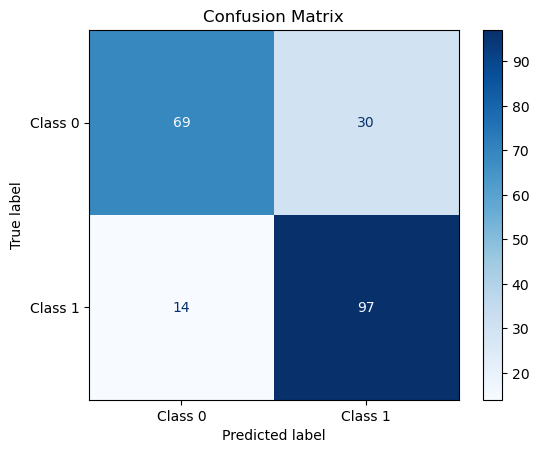

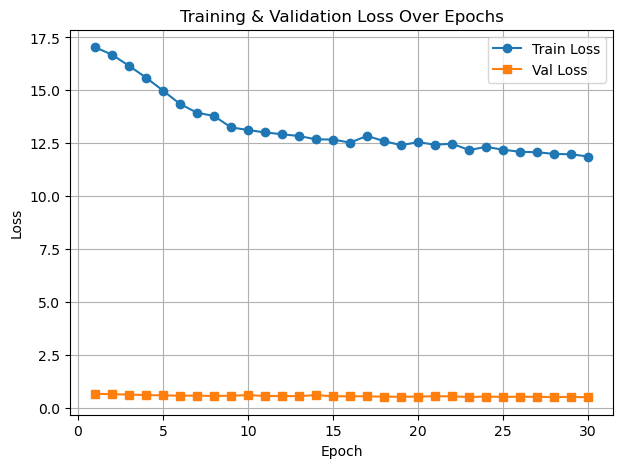

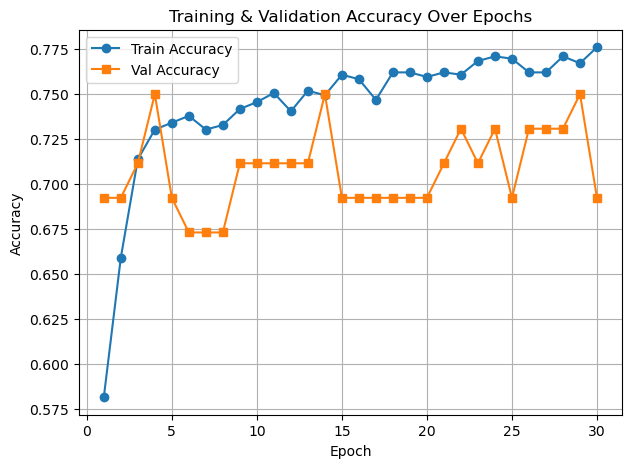

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader as GeometricDataLoader
from architectures.gnn_model import GNN  # Import the GNN model
from torch.utils.data.dataset import Subset
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Load dataset splits safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("datasets/binary_dataset/graph_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("datasets/binary_dataset/graph_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("datasets/binary_dataset/graph_datasets/test_set.pth", weights_only=False)


# Create GNN DataLoaders
batch_size = 32
train_loader = GeometricDataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = GeometricDataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = GeometricDataLoader(test_set, batch_size=batch_size, shuffle=False)

# Set device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize GNN model
input_dim, hidden_dim, output_dim = 3, 64, 1  # RGB channels as node features
model = GNN(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)
criterion = nn.BCEWithLogitsLoss()

# Track losses and accuracy for plots
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data.y.view(-1, 1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        
        # Store results for plotting
        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data.y.view(-1, 1))
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)
    
    return correct / total, running_loss / len(val_loader)

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

# Function to find the best threshold using AUC-ROC
def find_best_threshold(model, train_loader):
    """Find the best threshold using training data only (no validation)."""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)
            outputs = model(data)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = data.y.cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Use Youden’s J statistic to find the best threshold
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]

    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    # Plot ROC Curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

# Find best threshold from training data
best_threshold = find_best_threshold(model, train_loader)

# Test function using best threshold
def test_model(model, test_loader, threshold):
    """Evaluate the model on test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(data.y.cpu().numpy().flatten())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f} (Using Threshold: {threshold:.4f})")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on test set using best threshold
test_model(model, test_loader, best_threshold)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


Previous GNN but with more hidden dimensions (256 instead of 64) ReduceLROnPlateau

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
from architectures.gnn_model import GNN
import torch
from torch.utils.data.dataset import Subset
from torch_geometric.loader import DataLoader as GeometricDataLoader
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("datasets/binary_dataset/graph_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("datasets/binary_dataset/graph_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("datasets/binary_dataset/graph_datasets/test_set.pth", weights_only=False)

# Define DataLoaders
batch_size = 32
train_loader = GeometricDataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = GeometricDataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = GeometricDataLoader(test_set, batch_size=batch_size, shuffle=False)

# Get input feature size from dataset
input_dim = train_set[0].x.shape[1]  
hidden_dim = 256
output_dim = 1  # Binary classification

# Initialize GNN model
model = GNN(input_dim, hidden_dim, output_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=0.0001)

# **Learning Rate Scheduler**
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    model.train()
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            
            outputs = model(data)
            loss = criterion(outputs, data.y.float().unsqueeze(1))
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.unsqueeze(1)).sum().item()
            total += data.y.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)

        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

    return train_losses, val_losses, train_accs, val_accs

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data.y.float().unsqueeze(1))
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.unsqueeze(1)).sum().item()
            total += data.y.size(0)

    return correct / total, running_loss / len(val_loader)

# Train model with scheduler
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50)


# Function to find the best threshold using AUC-ROC
def find_best_threshold(model, train_loader):
    """Find the best threshold using training data only (no validation)."""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)
            outputs = model(data)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = data.y.cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Use Youden’s J statistic to find the best threshold
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]

    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    # Plot ROC Curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

# Find best threshold from training data
best_threshold = find_best_threshold(model, train_loader)

# Test function using best threshold
def test_model(model, test_loader, threshold):
    """Evaluate the model on test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(data.y.cpu().numpy().flatten())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f} (Using Threshold: {threshold:.4f})")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on test set using best threshold
test_model(model, test_loader, best_threshold)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

Graph Neural Network 2 which now has. GNN2 adds one more Convolution layer, it also adds switches to LeakyRelu instead of ReLU

/Users/marcobenavides/miniconda3/envs/ML4FG/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Using device: mps
Epoch 1/30 - Loss: 16.9611, Train Acc: 0.5891, Val Acc: 0.4808, Val Loss: 0.6917
Epoch 2/30 - Loss: 16.3086, Train Acc: 0.6578, Val Acc: 0.5962, Val Loss: 0.6744
Epoch 3/30 - Loss: 15.6328, Train Acc: 0.6908, Val Acc: 0.4808, Val Loss: 0.7010
Epoch 4/30 - Loss: 14.9551, Train Acc: 0.6908, Val Acc: 0.6538, Val Loss: 0.6312
Epoch 5/30 - Loss: 14.6367, Train Acc: 0.7137, Val Acc: 0.5769, Val Loss: 0.6696
Epoch 6/30 - Loss: 14.2771, Train Acc: 0.7303, Val Acc: 0.6731, Val Loss: 0.6022
Epoch 7/30 - Loss: 14.3533, Train Acc: 0.7087, Val Acc: 0.6923, Val Loss: 0.6152
Epoch 8/30 - Loss: 13.9804, Train Acc: 0.7125, Val Acc: 0.6923, Val Loss: 0.6304
Epoch 9/30 - Loss: 14.5345, Train Acc: 0.6883, Val Acc: 0.6731, Val Loss: 0.6362
Epoch 10/30 - Loss: 14.1453, Train Acc: 0.7036, Val Acc: 0.7115, Val Loss: 0.5768
Epoch 11/30 - Loss: 13.9375, Train Acc: 0.7328, Val Acc: 0.6538, Val Loss: 0.5933
Epoch 12/30 - Loss: 13.6421, Train Acc: 0.7201, Val Acc: 0.6154, Val Loss: 0.6323
Epoch 1

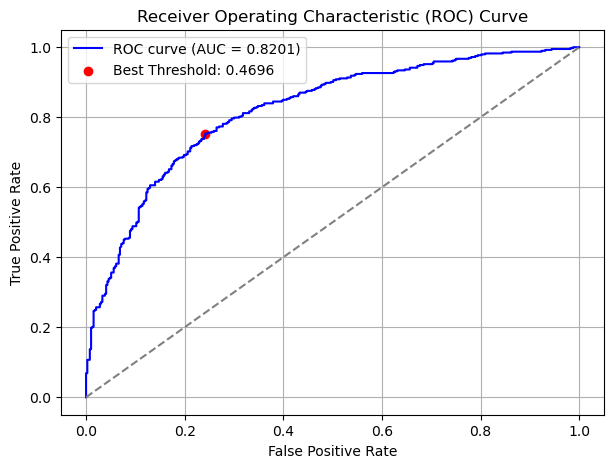

Test Accuracy: 0.7429 (Using Threshold: 0.4696)
Precision: 0.7355, Recall: 0.8018, F1-Score: 0.7672


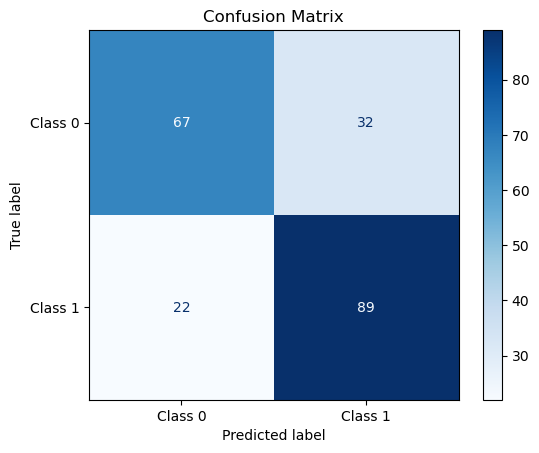

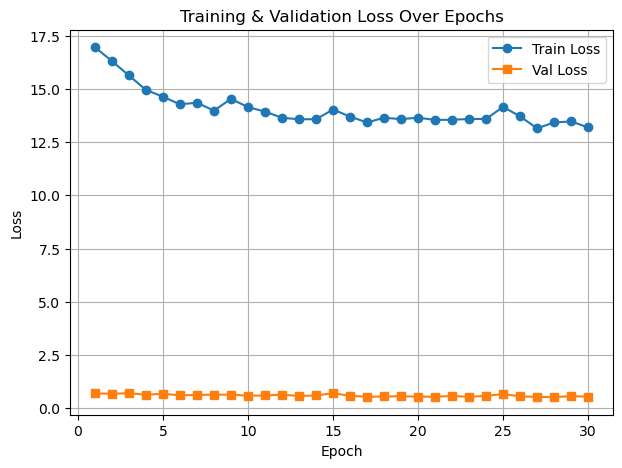

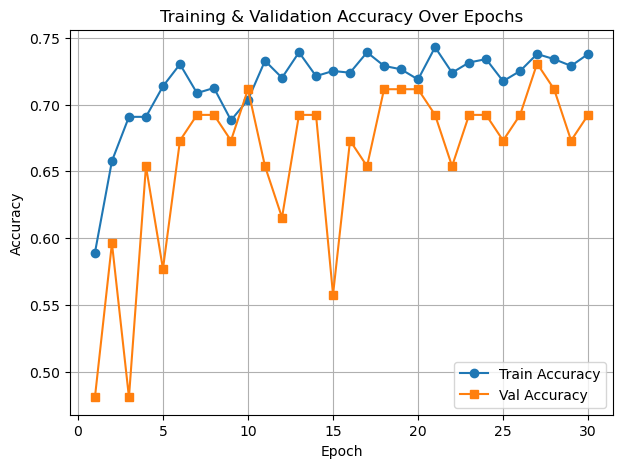

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader as GeometricDataLoader
import importlib
import architectures.gnn2_model  # Import the module first
importlib.reload(architectures.gnn2_model)
from architectures.gnn2_model import GNN  # Now import the class after reloading
from torch.utils.data.dataset import Subset
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Load dataset splits safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("datasets/binary_dataset/graph_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("datasets/binary_dataset/graph_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("binary_dataset/graph_datasets/test_set.pth", weights_only=False)

# Create GNN DataLoaders
batch_size = 32
train_loader = GeometricDataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = GeometricDataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = GeometricDataLoader(test_set, batch_size=batch_size, shuffle=False)

# Set device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize GNN model
input_dim, hidden_dim, output_dim = 3, 64, 1  # RGB channels as node features
model = GNN(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)
criterion = nn.BCEWithLogitsLoss()


# Track losses and accuracy for plots
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data.y.view(-1, 1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        
        # Store results for plotting
        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data.y.view(-1, 1))
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)
    
    return correct / total, running_loss / len(val_loader)

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

# Function to find the best threshold using AUC-ROC
def find_best_threshold(model, train_loader):
    """Find the best threshold using training data only (no validation)."""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)
            outputs = model(data)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = data.y.cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Use Youden’s J statistic to find the best threshold
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]

    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    # Plot ROC Curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

# Find best threshold from training data
best_threshold = find_best_threshold(model, train_loader)

# Test function using best threshold
def test_model(model, test_loader, threshold):
    """Evaluate the model on test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(data.y.cpu().numpy().flatten())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f} (Using Threshold: {threshold:.4f})")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on test set using best threshold
test_model(model, test_loader, best_threshold)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


Same GNN2 but this one has more hidden dimensions (from 64 to 256)

Using device: mps
Epoch 1/30 - Loss: 17.2693, Train Acc: 0.5712, Val Acc: 0.6538, Val Loss: 0.6425, LR: 0.003000
Epoch 2/30 - Loss: 16.2998, Train Acc: 0.6361, Val Acc: 0.6346, Val Loss: 0.6598, LR: 0.003000
Epoch 3/30 - Loss: 15.4384, Train Acc: 0.6768, Val Acc: 0.7308, Val Loss: 0.5829, LR: 0.003000
Epoch 4/30 - Loss: 14.7797, Train Acc: 0.7036, Val Acc: 0.4808, Val Loss: 0.7838, LR: 0.003000
Epoch 5/30 - Loss: 16.0295, Train Acc: 0.6641, Val Acc: 0.6346, Val Loss: 0.6423, LR: 0.003000
Epoch 6/30 - Loss: 15.5776, Train Acc: 0.6552, Val Acc: 0.6538, Val Loss: 0.6387, LR: 0.001500
Epoch 7/30 - Loss: 15.1595, Train Acc: 0.6819, Val Acc: 0.7115, Val Loss: 0.5947, LR: 0.001500
Epoch 8/30 - Loss: 14.4390, Train Acc: 0.7150, Val Acc: 0.6538, Val Loss: 0.6151, LR: 0.001500
Epoch 9/30 - Loss: 14.2409, Train Acc: 0.7036, Val Acc: 0.6731, Val Loss: 0.6260, LR: 0.000750
Epoch 10/30 - Loss: 13.4655, Train Acc: 0.7366, Val Acc: 0.6731, Val Loss: 0.5950, LR: 0.000750
Epoch 11/30 - Loss: 13.7863, Tr

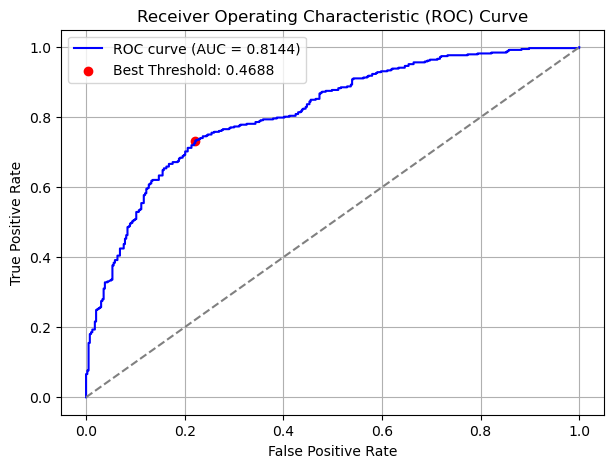

: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
from architectures.gnn2_model import GNN
import torch
from torch.utils.data.dataset import Subset
from torch_geometric.loader import DataLoader as GeometricDataLoader
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("datasets/binary_dataset/graph_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("datasets/binary_dataset/graph_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("datasets/binary_dataset/graph_datasets/test_set.pth", weights_only=False)

# Define DataLoaders
batch_size = 32
train_loader = GeometricDataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = GeometricDataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = GeometricDataLoader(test_set, batch_size=batch_size, shuffle=False)

# Get input feature size from dataset
input_dim = train_set[0].x.shape[1]  
hidden_dim = 256
output_dim = 1  # Binary classification

# Initialize GNN model
model = GNN(input_dim, hidden_dim, output_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0001)

# **Learning Rate Scheduler**
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, data.y.float().unsqueeze(1))
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.unsqueeze(1)).sum().item()
            total += data.y.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)

        # Step the scheduler
        scheduler.step(val_loss)

        # Get current learning rate
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = scheduler.get_last_lr()[0]

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data.y.float().unsqueeze(1))
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == data.y.unsqueeze(1)).sum().item()
            total += data.y.size(0)

    return correct / total, running_loss / len(val_loader)

# Train model with scheduler
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50)


# Function to find the best threshold using AUC-ROC
def find_best_threshold(model, train_loader):
    """Find the best threshold using training data only (no validation)."""
    model.eval()
    all_probs, all_labels = [], []
    
    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)
            outputs = model(data)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            labels = data.y.cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Use Youden’s J statistic to find the best threshold
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]

    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    # Plot ROC Curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

# Find best threshold from training data
best_threshold = find_best_threshold(model, train_loader)

# Test function using best threshold
def test_model(model, test_loader, threshold):
    """Evaluate the model on test set using the best threshold."""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == data.y.view(-1, 1)).sum().item()
            total += data.y.size(0)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(data.y.cpu().numpy().flatten())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f} (Using Threshold: {threshold:.4f})")

    # Compute Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate on test set using best threshold
test_model(model, test_loader, best_threshold)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

The model is still failing to learn, I will try a CNN to see if it works better or if the only reason the first two worked better is because it's a very complex architecture and doesn't take too long because it is transferred learning

Using device: mps
Epoch 1/10 - Train Loss: 123.7686, Train Acc: 0.6444, Val Acc: 0.6863, Val Loss: 1.3619
Epoch 2/10 - Train Loss: 17.0107, Train Acc: 0.7651, Val Acc: 0.7647, Val Loss: 0.6066
Epoch 3/10 - Train Loss: 9.9983, Train Acc: 0.8344, Val Acc: 0.7843, Val Loss: 0.5252
Epoch 4/10 - Train Loss: 8.2946, Train Acc: 0.8742, Val Acc: 0.6667, Val Loss: 0.8440
Epoch 5/10 - Train Loss: 8.1210, Train Acc: 0.8665, Val Acc: 0.5882, Val Loss: 0.6598
Epoch 6/10 - Train Loss: 7.7345, Train Acc: 0.8678, Val Acc: 0.7255, Val Loss: 0.6817
Epoch 7/10 - Train Loss: 4.1659, Train Acc: 0.9474, Val Acc: 0.7451, Val Loss: 0.6786
Epoch 8/10 - Train Loss: 3.0186, Train Acc: 0.9679, Val Acc: 0.7451, Val Loss: 0.7282
Epoch 9/10 - Train Loss: 1.6354, Train Acc: 0.9897, Val Acc: 0.7843, Val Loss: 0.7622
Epoch 10/10 - Train Loss: 1.2216, Train Acc: 0.9949, Val Acc: 0.8039, Val Loss: 0.8148
Best threshold found: 0.5284 (AUC: 0.7840)


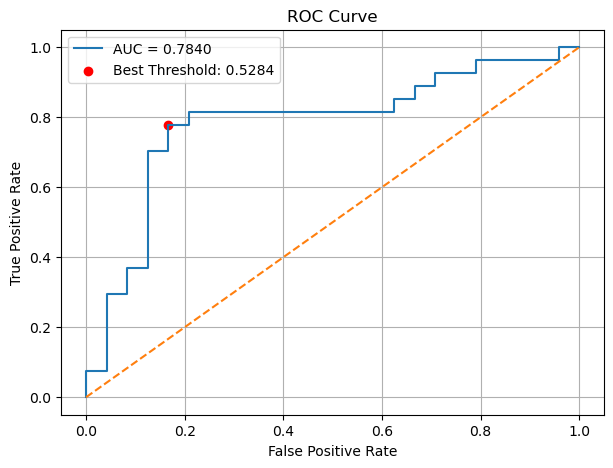

Test Accuracy: 0.7225 — Precision: 0.7315, Recall: 0.7315, F1: 0.7315


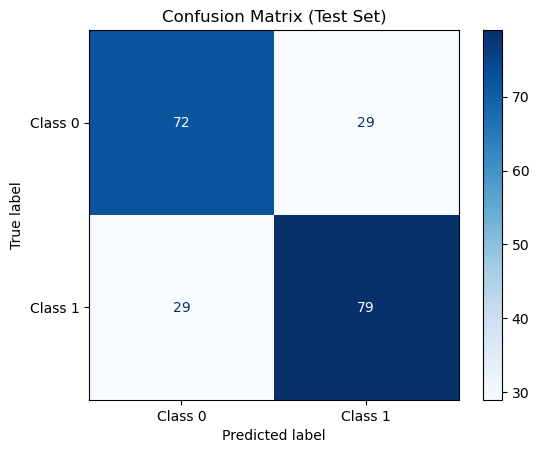

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from sklearn.metrics import ( roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay)
from architectures.cnn import CustomCNN

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# === Load dataset ===
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("datasets/binary_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("datasets/binary_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("datasets/binary_dataset/image_datasets/test_set.pth", weights_only=False)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# === Model, Loss, Optimizer ===
model = CustomCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

# === Training ===
def validate_model(model, loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total, running_loss / len(loader)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# === Find Best Threshold on Validation Set ===
def find_best_threshold(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy().flatten())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    best_idx = (tpr - fpr).argmax()
    best_threshold = thresholds[best_idx]
    print(f"Best threshold found: {best_threshold:.4f} (AUC: {roc_auc:.4f})")

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold

best_threshold = find_best_threshold(model, val_loader)

# === Test with Best Threshold ===
def test_model(model, loader, threshold):
    model.eval()
    all_preds, all_labels = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    acc = correct / total
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f} — Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix (Test Set)")
    plt.show()

test_model(model, test_loader, best_threshold)


Based on the previous architecture we can see that we don't need a very complex architecture to get the same results (Resnet Results were: Epoch 30/30 - Loss: 0.3731, Train Acc: 0.9949, Val Acc: 0.8235, Val Loss: 1.0171) as we got from the Resnet which is more robust and significantly more complex.

Because the GNN did not perform well:

Epoch 30/30 - Loss: 12.8415, Train Acc: 0.7445, Val Acc: 0.7647, Val Loss: 0.5048 in 114 minutes. And the model plateaud basically somewhere around epoch 9. Although we do see that the GNN does not overfit as the training accuracy is the same as the validation accuracy.


Now we will escalate the previous CNN but for multiclass classification. We wil add bacterial antigens and bacterial non antigens

Generate the train, test and validation set on the multiclass classification

In [ ]:
import os
import glob
import random
import torch
import shutil
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from pathlib import Path
from torch.utils.data import Subset

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Define paths
base_dir = Path().resolve()
dataset_root = base_dir / "datasets"
original_datasets = dataset_root / "original_datasets"

# Source folders
data_dir_immunogenic = original_datasets / "tumor_antigens_immunogenic" / "voronoi_images"
data_dir_non_immunogenic = original_datasets / "tumor_antigens_non-immunogenic" / "voronoi_images"
data_dir_bacterial_immunogenic = original_datasets / "bacterial_antigens" / "voronoi_images"
data_dir_bacterial_non_immunogenic = original_datasets / "bacterial_non_antigens" / "voronoi_images"

# Target folders
multiclass_dir = dataset_root / "multiclass_dataset" / "multiclass"
image_data_dir = dataset_root / "multiclass_dataset" / "image_datasets"

tumor_immunogenic_dir = multiclass_dir / "tumor_immunogenic"
tumor_non_immunogenic_dir = multiclass_dir / "tumor_non_immunogenic"
bacterial_immunogenic_dir = multiclass_dir / "bacterial_immunogenic"
bacterial_non_immunogenic_dir = multiclass_dir / "bacterial_non_immunogenic"

# Create necessary directories
for d in [tumor_immunogenic_dir, tumor_non_immunogenic_dir, bacterial_immunogenic_dir, bacterial_non_immunogenic_dir, image_data_dir]:
    d.mkdir(parents=True, exist_ok=True)

# Copy images if not already copied
if not any(p.iterdir() for p in [tumor_immunogenic_dir, tumor_non_immunogenic_dir, bacterial_immunogenic_dir, bacterial_non_immunogenic_dir]):
    print("Copying images into class-labeled folders...")
    for src_dir, dst_dir in [
        (data_dir_immunogenic, tumor_immunogenic_dir),
        (data_dir_non_immunogenic, tumor_non_immunogenic_dir),
        (data_dir_bacterial_immunogenic, bacterial_immunogenic_dir),
        (data_dir_bacterial_non_immunogenic, bacterial_non_immunogenic_dir),
    ]:
        for img_path in glob.glob(str(src_dir / "*.png")):
            shutil.copy(img_path, dst_dir / Path(img_path).name)
    print("Dataset successfully copied and organized.")
else:
    print("Dataset already organized. Skipping file copy.")

# Validate directories are not empty
for d in [tumor_immunogenic_dir, tumor_non_immunogenic_dir, bacterial_immunogenic_dir, bacterial_non_immunogenic_dir]:
    if not any(d.iterdir()):
        raise FileNotFoundError(f"Error: Directory {d} is empty.")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Paths for serialized splits
train_set_path = image_data_dir / "train_set.pth"
val_set_path = image_data_dir / "val_set.pth"
test_set_path = image_data_dir / "test_set.pth"

# Process dataset if not already done
if not (train_set_path.exists() and val_set_path.exists() and test_set_path.exists()):
    print("Processing image dataset...")
    dataset = ImageFolder(root=multiclass_dir, transform=transform)

    train_size = int(0.75 * len(dataset))
    val_size = int(0.05 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    torch.save(train_set, train_set_path)
    torch.save(val_set, val_set_path)
    torch.save(test_set, test_set_path)
    print(f"Image dataset saved in {image_data_dir}. Train: {train_size}, Val: {val_size}, Test: {test_size}")
else:
    print("Image dataset already processed. Skipping dataset split.")

# Load datasets with Subset allowed
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load(train_set_path, weights_only=False)
    val_set = torch.load(val_set_path, weights_only=False)
    test_set = torch.load(test_set_path, weights_only=False)

print(f"Train Samples: {len(train_set)}, Val Samples: {len(val_set)}, Test Samples: {len(test_set)}")


Dataset already organized. Skipping file copy.
Image dataset already processed. Skipping dataset split.
Train Samples: 1175, Val Samples: 78, Test Samples: 314


Generate the train, test and validation set on the multiclass classification for the graphs

In [ ]:
import torch
import random
from pathlib import Path
import torch_geometric
from torch_geometric.data import Data

# === Allow safe unpickling of PyTorch Geometric data types
torch.serialization.add_safe_globals([
    torch_geometric.data.Data,
    torch_geometric.data.Batch,
])

# === Set seed
random.seed(42)

# === Define base directory dynamically
base_dir = Path().resolve()
original_datasets = base_dir / "datasets" / "original_datasets"

# === Define graph input paths
paths = {
    "immunogenic": original_datasets / "tumor_antigens_immunogenic" / "graphs",
    "non_immunogenic": original_datasets / "tumor_antigens_non-immunogenic" / "graphs",
    "bacterial_non_antigens": original_datasets / "bacterial_non_antigens" / "graphs",
    "bacterial_antigens": original_datasets / "bacterial_antigens" / "graphs",
}

# === Class labels
class_labels = {
    "immunogenic": 0,
    "non_immunogenic": 1,
    "bacterial_non_antigens": 2,
    "bacterial_antigens": 3,
}

# === Output path
output_dir = base_dir / "datasets" / "multiclass_dataset" / "graph_datasets"
output_dir.mkdir(parents=True, exist_ok=True)

# === Load and label data
data = []
label_counts = {label: 0 for label in class_labels.values()}

for category, path in paths.items():
    if path.exists():
        files = [(f, class_labels[category]) for f in path.glob("*.pth")]
        data.extend(files)
        label_counts[class_labels[category]] += len(files)

# === Shuffle and split
random.shuffle(data)
total = len(data)
train_size = int(0.75 * total)
val_size = int(0.05 * total)
test_size = total - train_size - val_size

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# === Save function
def save_dataset(data_split, filename):
    dataset = []
    local_counts = {label: 0 for label in class_labels.values()}
    for file_path, label in data_split:
        graph_data = torch.load(file_path, weights_only=False)
        graph_data.y = torch.tensor([label], dtype=torch.long)
        dataset.append(graph_data)
        local_counts[label] += 1
    torch.save(dataset, output_dir / filename)
    return local_counts

# === Save and report
train_counts = save_dataset(train_data, "train_set.pth")
val_counts = save_dataset(val_data, "val_set.pth")
test_counts = save_dataset(test_data, "test_set.pth")

# === Print summary
def print_counts(name, counts, total):
    print(f"\n{name} samples: {total}")
    for label, count in counts.items():
        print(f"  Class {label}: {count}")

print_counts("Training", train_counts, len(train_data))
print_counts("Validation", val_counts, len(val_data))
print_counts("Test", test_counts, len(test_data))

print(f"\nDatasets saved in: {output_dir}")



Training samples: 1182
  Class 0: 386
  Class 1: 409
  Class 2: 233
  Class 3: 154

Validation samples: 78
  Class 0: 29
  Class 1: 22
  Class 2: 17
  Class 3: 10

Test samples: 316
  Class 0: 113
  Class 1: 89
  Class 2: 63
  Class 3: 51

Datasets saved in /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/graph_datasets


Class 0: Tumor Immunogenic (520)
Class 1: Tumor Non-Immunogenic (528)
Class 2: Bacterial Non-Immunogenic (314)
Class 3: Bacterial Immunogenic (215)

Now that we have the multiclass dataset we will run the previous CNN and see how it performs

Using device: mps
Epoch 1/10 - Loss: 276.8586, Train Acc: 0.3506, Val Acc: 0.4359, Val Loss: 1.4147
Epoch 2/10 - Loss: 33.4620, Train Acc: 0.6213, Val Acc: 0.5513, Val Loss: 0.9653
Epoch 3/10 - Loss: 20.7768, Train Acc: 0.7736, Val Acc: 0.7051, Val Loss: 0.5885
Epoch 4/10 - Loss: 16.0054, Train Acc: 0.8196, Val Acc: 0.6795, Val Loss: 0.6385
Epoch 5/10 - Loss: 10.8364, Train Acc: 0.8970, Val Acc: 0.7051, Val Loss: 0.6638
Epoch 6/10 - Loss: 8.6639, Train Acc: 0.9166, Val Acc: 0.7051, Val Loss: 0.6305
Epoch 7/10 - Loss: 5.5611, Train Acc: 0.9600, Val Acc: 0.7436, Val Loss: 0.5927
Epoch 8/10 - Loss: 5.2949, Train Acc: 0.9591, Val Acc: 0.7308, Val Loss: 0.6508
Epoch 9/10 - Loss: 2.9325, Train Acc: 0.9838, Val Acc: 0.7308, Val Loss: 0.6968
Epoch 10/10 - Loss: 1.6963, Train Acc: 0.9923, Val Acc: 0.7179, Val Loss: 0.7817
Test Accuracy: 0.7420
Precision: 0.7572, Recall: 0.7420, F1-Score: 0.7341


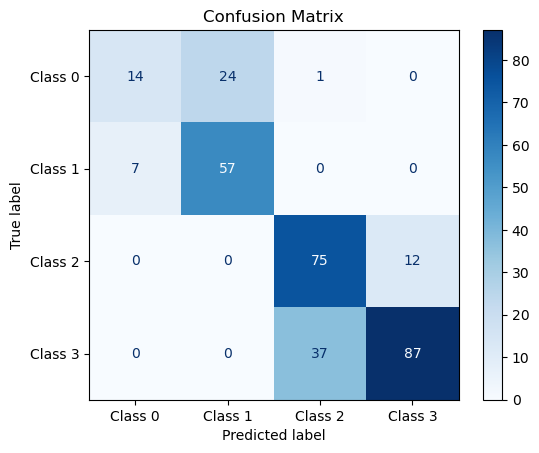

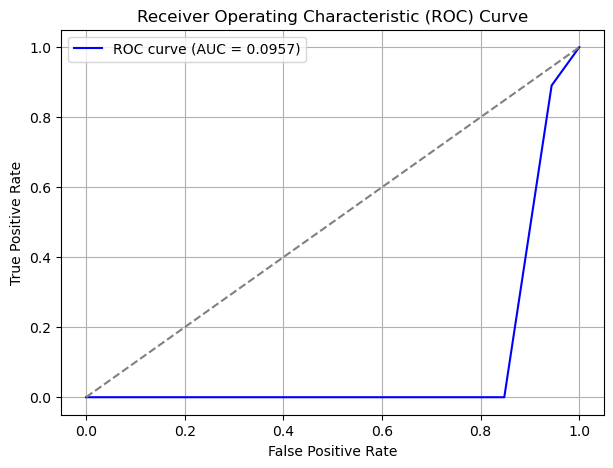

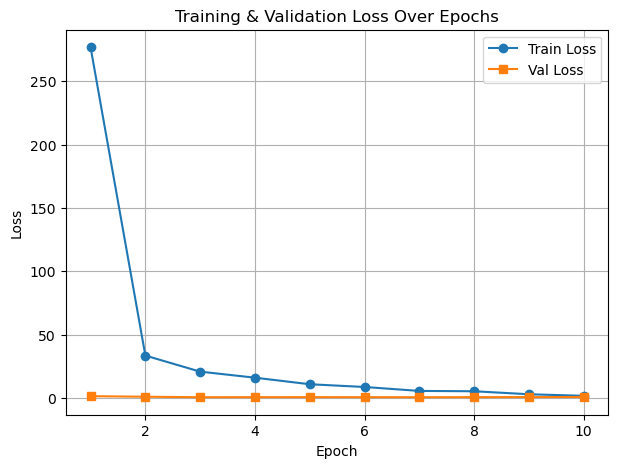

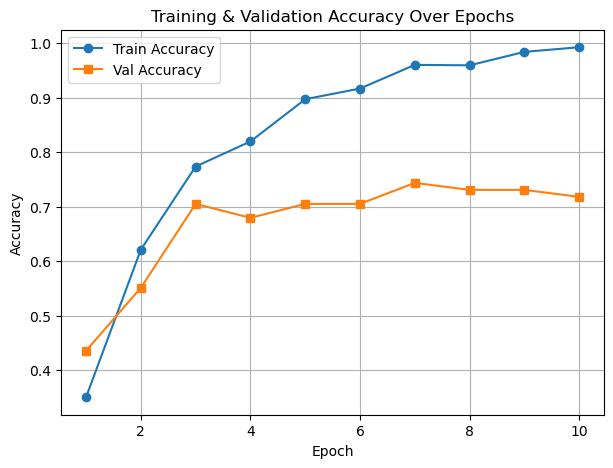

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score
)
from architectures.cnn import CustomCNN 

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# === Dataset paths ===
base_dir = Path().resolve()
image_dataset_dir = base_dir / "datasets" / "multiclass_dataset" / "image_datasets"

with torch.serialization.safe_globals([Subset]):
    train_set = torch.load(image_dataset_dir / "train_set.pth", weights_only=False)
    val_set = torch.load(image_dataset_dir / "val_set.pth", weights_only=False)
    test_set = torch.load(image_dataset_dir / "test_set.pth", weights_only=False)

# === DataLoaders ===
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# === Model, loss, optimizer ===
model = CustomCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# === Training ===
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)

        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total, running_loss / len(val_loader)

def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(4)])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# === Run training and testing ===
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
test_model(model, test_loader)

# === Plotting training history ===
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(val_accs, label='Val Accuracy', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()
plt.show()


In the following code I use the previous multiclass CNN but on hte new augmented dataset:

Using device: mps
Epoch 1/10 - Loss: 368.6835, Train Acc: 0.3821, Val Acc: 0.4000, Val Loss: 1.3125
Epoch 2/10 - Loss: 131.4576, Train Acc: 0.4996, Val Acc: 0.4723, Val Loss: 1.1676
Epoch 3/10 - Loss: 122.7137, Train Acc: 0.5376, Val Acc: 0.5234, Val Loss: 1.1121
Epoch 4/10 - Loss: 106.0717, Train Acc: 0.5940, Val Acc: 0.5447, Val Loss: 0.9938
Epoch 5/10 - Loss: 93.8926, Train Acc: 0.6468, Val Acc: 0.5362, Val Loss: 1.0039
Epoch 6/10 - Loss: 77.7159, Train Acc: 0.7180, Val Acc: 0.5191, Val Loss: 1.1355
Epoch 7/10 - Loss: 67.9180, Train Acc: 0.7509, Val Acc: 0.5021, Val Loss: 1.1727
Epoch 8/10 - Loss: 48.9589, Train Acc: 0.8301, Val Acc: 0.5191, Val Loss: 1.3544
Epoch 9/10 - Loss: 33.4103, Train Acc: 0.8905, Val Acc: 0.4894, Val Loss: 1.5255
Epoch 10/10 - Loss: 22.1187, Train Acc: 0.9348, Val Acc: 0.5149, Val Loss: 1.8031
Test Accuracy: 0.5069
Precision: 0.5362, Recall: 0.5069, F1: 0.5053


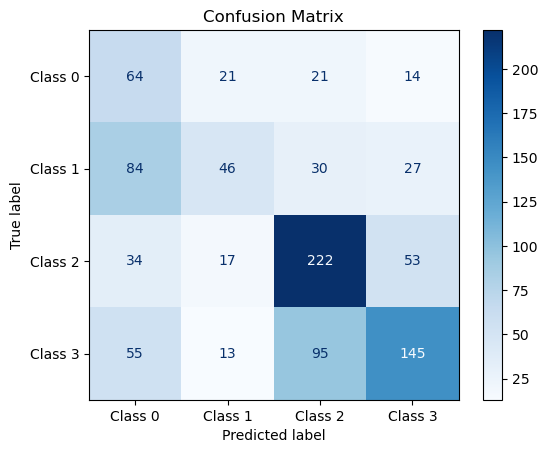

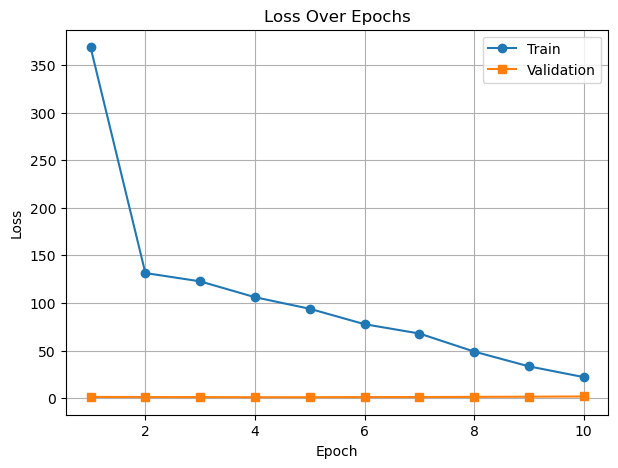

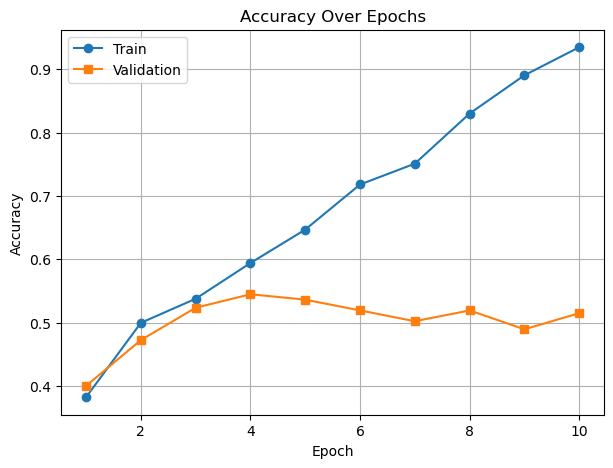

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
from architectures.cnn_multiclass import CustomCNN  # Modular import

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# === Load dataset ===
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("datasets/data_augmented_multiclass_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("datasets/data_augmented_multiclass_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("datasets/data_augmented_multiclass_dataset/image_datasets/test_set.pth", weights_only=False)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# === Model, Loss, Optimizer ===
model = CustomCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# === Training ===
def validate_model(model, loader, criterion):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            loss_sum += loss.item()
            total += labels.size(0)
    return correct / total, loss_sum / len(loader)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        correct, total, loss_sum = 0, 0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            loss_sum += loss.item()
            total += labels.size(0)
        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        train_losses.append(loss_sum)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss_sum:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

# === Test Evaluation ===
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}, Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}, F1: {f1_score(all_labels, all_preds, average='weighted'):.4f}")
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(4)]).plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# === Run Training & Evaluation ===
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
test_model(model, test_loader)

# === Plot Metrics ===
def plot_metric(metric_list, title, ylabel):
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, len(metric_list[0]) + 1), metric_list[0], label='Train', marker='o')
    plt.plot(range(1, len(metric_list[1]) + 1), metric_list[1], label='Validation', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_metric((train_losses, val_losses), "Loss Over Epochs", "Loss")
plot_metric((train_accs, val_accs), "Accuracy Over Epochs", "Accuracy")


THe model kept overfitting even with an augmented dataset. So I balanced the augmented dataset

Using device: mps
Epoch 1/50 | Loss: 3514.0522 | Train Acc: 0.2522 | Val Acc: 0.1532 | Val Loss: 1.3896
Epoch 2/50 | Loss: 162.0477 | Train Acc: 0.2522 | Val Acc: 0.1532 | Val Loss: 1.3913
Epoch 3/50 | Loss: 154.8307 | Train Acc: 0.2664 | Val Acc: 0.1532 | Val Loss: 1.3995
Epoch 4/50 | Loss: 154.1503 | Train Acc: 0.2494 | Val Acc: 0.2128 | Val Loss: 1.3953
Epoch 5/50 | Loss: 153.8601 | Train Acc: 0.2590 | Val Acc: 0.2128 | Val Loss: 1.3927
Epoch 6/50 | Loss: 153.9414 | Train Acc: 0.2465 | Val Acc: 0.2128 | Val Loss: 1.3883
Epoch 7/50 | Loss: 153.8924 | Train Acc: 0.2411 | Val Acc: 0.1532 | Val Loss: 1.3879
Epoch 8/50 | Loss: 153.9003 | Train Acc: 0.2434 | Val Acc: 0.2128 | Val Loss: 1.3860
Epoch 9/50 | Loss: 153.8863 | Train Acc: 0.2477 | Val Acc: 0.3489 | Val Loss: 1.3854
Epoch 10/50 | Loss: 154.1021 | Train Acc: 0.2391 | Val Acc: 0.3489 | Val Loss: 1.3857
Epoch 11/50 | Loss: 153.9252 | Train Acc: 0.2437 | Val Acc: 0.3489 | Val Loss: 1.3857
Epoch 12/50 | Loss: 153.8854 | Train Acc: 0.

/Users/marcobenavides/miniforge3/envs/ML4FG/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


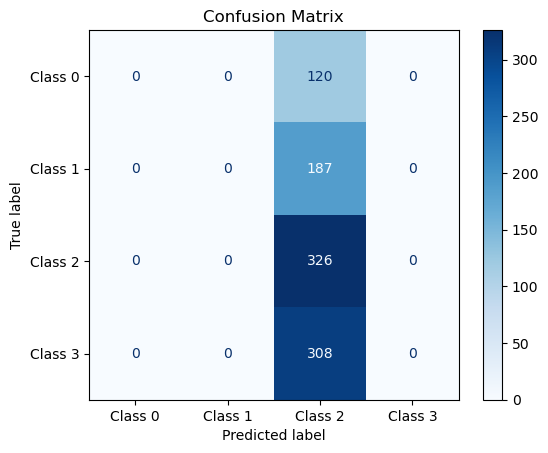

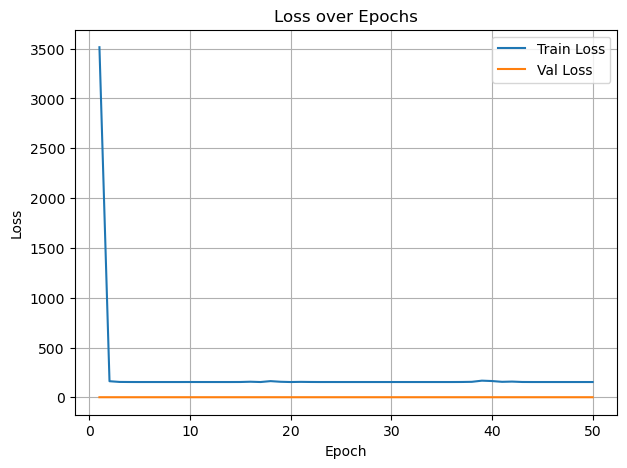

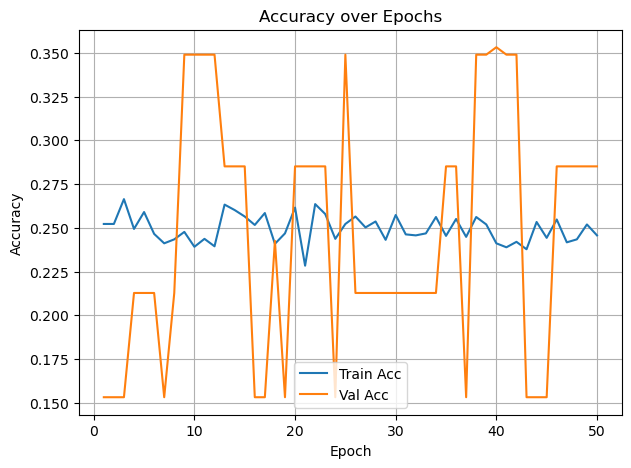

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from collections import Counter
from torch.optim.lr_scheduler import CosineAnnealingLR
from architectures.cnn_multiclass import CustomCNN

# === Device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# === Paths
base_dir = Path().resolve()
dataset_dir = base_dir / "datasets/data_augmented_multiclass_dataset" / "image_datasets"
train_path = dataset_dir / "train_set.pth"
val_path = dataset_dir / "val_set.pth"
test_path = dataset_dir / "test_set.pth"

# === Load Data
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load(train_path, weights_only=False)
    val_set = torch.load(val_path, weights_only=False)
    test_set = torch.load(test_path, weights_only=False)

# === Compute Class Weights
labels = [label for _, label in train_set]
class_counts = Counter(labels)
num_samples = len(labels)
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# === DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

# === Model
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# === Tracking
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_loss = float('inf')
no_improve_epochs = 0
early_stop_patience = 10

# === Validation
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loss_sum += loss.item()
    return correct / total, loss_sum / len(val_loader)

# === Train
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    global best_val_loss, no_improve_epochs
    for epoch in range(num_epochs):
        model.train()
        correct, total, loss_sum = 0, 0, 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loss_sum += loss.item()

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        scheduler.step()

        train_losses.append(loss_sum)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss_sum:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

# === Test
def test_model(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall:    {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1 Score:  {f1_score(all_labels, all_preds, average='weighted'):.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(4)])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# === Run Training & Evaluation
train_model(model, train_loader, val_loader, criterion, optimizer)
test_model(model, test_loader)

# === Plotting
def plot_training_curves():
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Acc')
    plt.plot(range(1, len(val_accs)+1), val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

plot_training_curves()


After this previous result I decide to do the ResNet with no freezing layers but now on multiclass classification as this was the model that best performed in binary classification.

Using device: mps


/Users/marcobenavides/miniforge3/envs/ML4FG/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcobenavides/miniforge3/envs/ML4FG/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([32, 4])
Sample logits: tensor([ 0.3478, -0.9668,  1.0675, -0.7385], device='mps:0',
       grad_fn=<SelectBackward0>)
Label shape: torch.Size([32])
Sample labels: tensor([3, 2, 2, 2, 0, 2, 3, 2, 1, 1], device='mps:0')
Unique labels in batch: tensor([0, 1, 2, 3], device='mps:0')
Epoch 1/10 - Loss: 25.0701, Train Acc: 0.6962, Val Acc: 0.5256, Val Loss: 0.8522
Epoch 2/10 - Loss: 13.9117, Train Acc: 0.8468, Val Acc: 0.6410, Val Loss: 0.7151
Epoch 3/10 - Loss: 6.6554, Train Acc: 0.9362, Val Acc: 0.6154, Val Loss: 1.4182
Epoch 4/10 - Loss: 3.4387, Train Acc: 0.9702, Val Acc: 0.5385, Val Loss: 1.9892
Epoch 5/10 - Loss: 2.0129, Train Acc: 0.9813, Val Acc: 0.7051, Val Loss: 0.9315
Epoch 6/10 - Loss: 1.7534, Train Acc: 0.9830, Val Acc: 0.6923, Val Loss: 1.4890
Epoch 7/10 - Loss: 2.2838, Train Acc: 0.9796, Val Acc: 0.6026, Val Loss: 1.4583
Epoch 8/10 - Loss: 2.9717, Train Acc: 0.9753, Val Acc: 0.6410, Val Loss: 1.6219
Epoch 9/10 - Loss: 2.1852, Train Acc: 0.9770, Val Acc

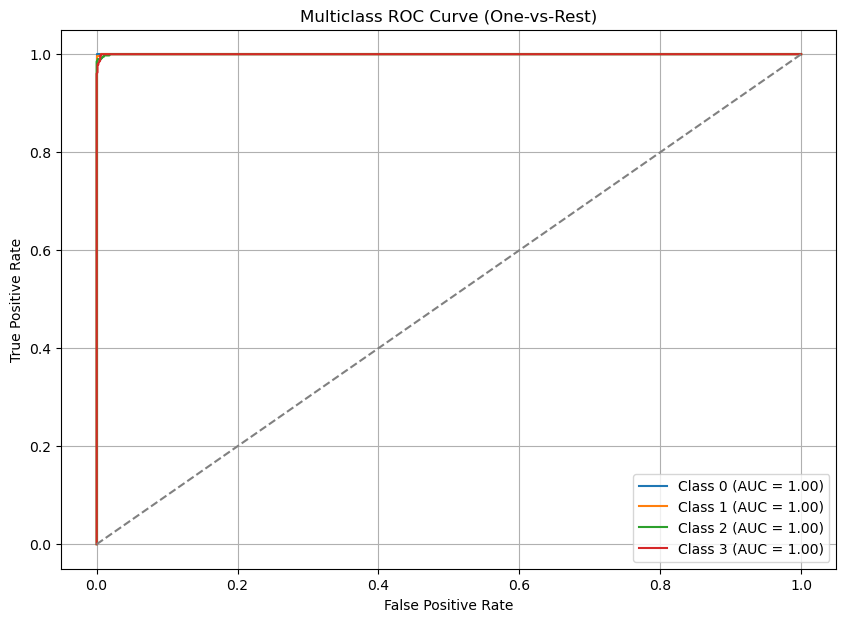

Test Accuracy: 0.7293
Precision: 0.7361
Recall: 0.7293
F1-Score: 0.7312


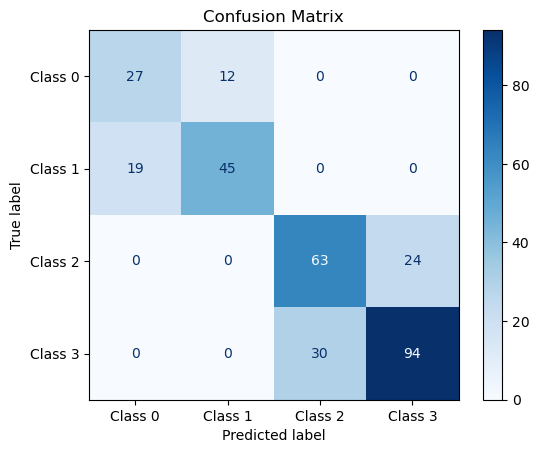

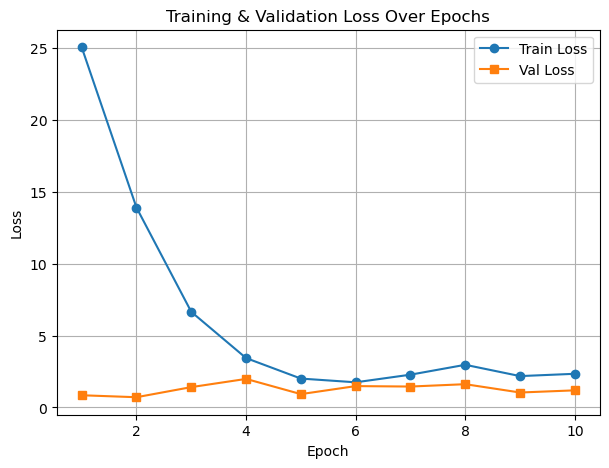

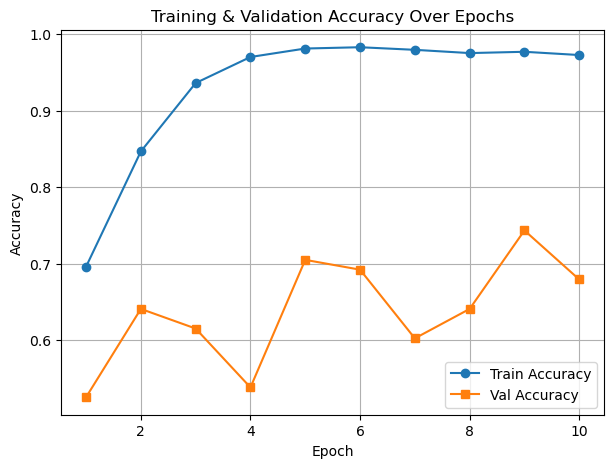

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from architectures.benchmark_ResNet18_multiclass import make_model  # Import ResNet18 model
from torch.utils.data.dataset import Subset
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load dataset splits safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("datasets/multiclass_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("datasets/multiclass_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("datasets/multiclass_dataset/image_datasets/test_set.pth", weights_only=False)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Set device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load ResNet18 model
model = make_model("resnet18", feature_extracting=False, use_pretrained=True).to(device)

# Define loss function and optimizer (now Cross Entropy for multiclass)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

# Track losses and accuracy for plots
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if epoch == 0 and batch_idx == 0:
                print("Output shape:", outputs.shape)
                print("Sample logits:", outputs[0])
                print("Label shape:", labels.shape)
                print("Sample labels:", labels[:10])
                print("Unique labels in batch:", labels.unique())

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)

        train_losses.append(running_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")


# Validation function


def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1) #changed from sigmoid to argmax

            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total, running_loss / len(val_loader)

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Function to find the best threshold using AUC-ROC
from sklearn.preprocessing import label_binarize

def find_best_threshold_multiclass(model, loader, n_classes=4):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    binarized_labels = label_binarize(all_labels, classes=list(range(n_classes)))

    # Plot ROC curves for each class
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(binarized_labels[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve (One-vs-Rest)")
    plt.legend()
    plt.grid()
    plt.show()

find_best_threshold_multiclass(model, train_loader)


# Test function using best threshold
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Test Accuracy: {correct / total:.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(4)])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

test_model(model, test_loader)


# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


11.	Finally, I tried the ResNet18 pretrained model but with oversampling of the undersampled class and the data augmentation.

Using device: mps


/Users/marcobenavides/miniforge3/envs/ML4FG/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcobenavides/miniforge3/envs/ML4FG/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 - Loss: 114.9960, Train Acc: 0.6167, Val Acc: 0.6340, Val Loss: 1.0722
Epoch 2/50 - Loss: 85.7889, Train Acc: 0.7787, Val Acc: 0.6638, Val Loss: 0.9761
Epoch 3/50 - Loss: 69.9593, Train Acc: 0.8630, Val Acc: 0.5957, Val Loss: 1.0978
Epoch 4/50 - Loss: 58.8006, Train Acc: 0.9251, Val Acc: 0.6894, Val Loss: 0.9641
Epoch 5/50 - Loss: 50.7430, Train Acc: 0.9665, Val Acc: 0.6170, Val Loss: 1.0221
Epoch 6/50 - Loss: 45.9946, Train Acc: 0.9844, Val Acc: 0.7319, Val Loss: 0.9311
Epoch 7/50 - Loss: 43.5296, Train Acc: 0.9929, Val Acc: 0.7277, Val Loss: 0.8861
Epoch 8/50 - Loss: 41.8245, Train Acc: 0.9963, Val Acc: 0.7404, Val Loss: 0.8705
Epoch 9/50 - Loss: 41.1204, Train Acc: 0.9983, Val Acc: 0.7319, Val Loss: 0.8654
Epoch 10/50 - Loss: 41.2349, Train Acc: 0.9989, Val Acc: 0.7064, Val Loss: 0.8829
Epoch 11/50 - Loss: 40.7412, Train Acc: 0.9991, Val Acc: 0.7191, Val Loss: 0.8690
Epoch 12/50 - Loss: 40.7464, Train Acc: 0.9997, Val Acc: 0.7404, Val Loss: 0.8673
Epoch 13/50 - Loss: 40.5

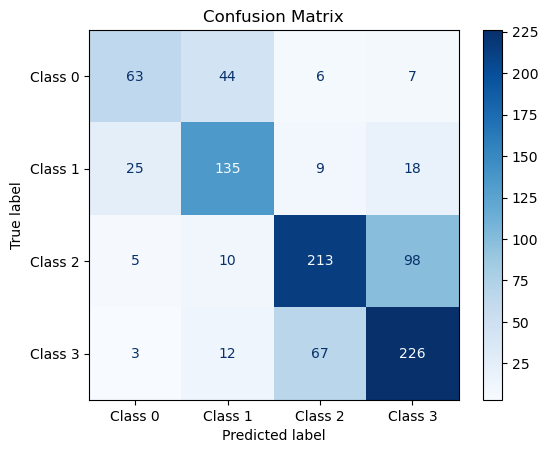

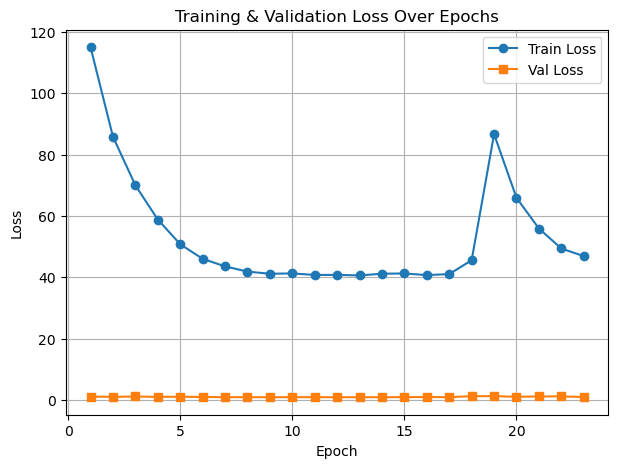

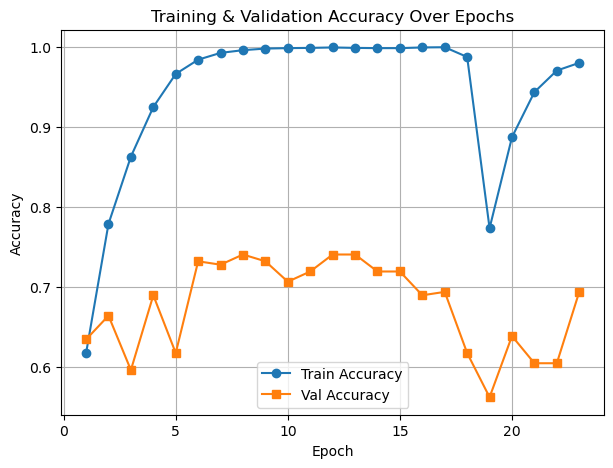

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.data.dataset import Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torch.optim.lr_scheduler import CosineAnnealingLR
from architectures.benchmark_ResNet18_multiclass import make_model

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("datasets/data_augmented_multiclass_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("datasets/data_augmented_multiclass_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("datasets/data_augmented_multiclass_dataset/image_datasets/test_set.pth", weights_only=False)

# Compute class weights for oversampling
labels = [label for _, label in train_set]
class_counts = Counter(labels)
num_samples = len(labels)
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, optimizer
model = make_model("resnet18", feature_extracting=False, use_pretrained=True).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Track losses and accuracy
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Early stopping variables
early_stop_patience = 10
no_improve_epochs = 0
best_val_loss = float('inf')

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    global no_improve_epochs, best_val_loss
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        scheduler.step()

        train_losses.append(running_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= early_stop_patience:
                print("Early stopping triggered.")
                break

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total, running_loss / len(val_loader)

# Test function
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Test Accuracy: {correct / total:.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(4)])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Run training and evaluation
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)
test_model(model, test_loader)

# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


Getting some examples of correctly predicted proteins:

Since the ResNet pretrained model didn't show a great validation metric I decided to implement the last model which would be a CNN model with a transformer model. it concatenates both outputs and feeds into a shared classifier 

In [26]:
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

# === Constants ===
AA_CODES = [
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE",
    "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"
]
AA_TO_INDEX = {aa: idx for idx, aa in enumerate(AA_CODES)}

# === Helper Functions ===
def extract_sequence_from_pdb(pdb_path):
    from Bio import PDB
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    return [
        residue.get_resname()
        for model in structure
        for chain in model
        for residue in chain
        if residue.get_resname() in AA_TO_INDEX
    ]

def one_hot_encode_sequence(sequence):
    onehot = np.zeros((len(sequence), len(AA_CODES)), dtype=int)
    for i, aa in enumerate(sequence):
        if aa in AA_TO_INDEX:
            onehot[i, AA_TO_INDEX[aa]] = 1
    return onehot

# === Dataset Matching Logic ===
def match_image_and_sequence_files(base_dir, classes):
    image_paths, onehot_paths, labels = [], [], []
    missing_csv_list = []

    for class_index, class_name in enumerate(classes):
        img_dir = os.path.join(base_dir, class_name, "voronoi_images")
        onehot_dir = os.path.join(base_dir, class_name, "onehot_sequences")

        for img_path in glob.glob(os.path.join(img_dir, "*.png")):
            base = os.path.basename(img_path)
            clean_name = base.replace(".pdb.png", "").replace(".png", "")
            if clean_name.startswith("AF_REMOTE_AF-"):
                clean_name = clean_name.replace("AF_REMOTE_", "")

            candidates = [
                f"{clean_name}_onehot.csv",
                f"{clean_name}.csv",
                f"{base}.csv"
            ]

            onehot_path = next(
                (os.path.join(onehot_dir, name) for name in candidates if os.path.exists(os.path.join(onehot_dir, name))),
                None
            )

            if onehot_path:
                image_paths.append(img_path)
                onehot_paths.append(onehot_path)
                labels.append(class_index)
            else:
                print(f"Missing CSV for: {clean_name}")
                missing_csv_list.append(clean_name)

    with open("missing_csv_log.txt", "w") as f:
        f.writelines(name + "\n" for name in missing_csv_list)

    print(f"Total matched pairs: {len(image_paths)}")
    if not image_paths:
        raise ValueError("No matched image and sequence pairs found.")

    return image_paths, onehot_paths, labels

# === Main Execution ===
if __name__ == "__main__":
    base_dir = "datasets/original_datasets"
    classes = [
        "tumor_antigens_non-immunogenic",
        "tumor_antigens_immunogenic",
        "bacterial_non_antigens",
        "bacterial_antigens"
    ]

    image_paths, onehot_paths, labels = match_image_and_sequence_files(base_dir, classes)

    train_img, test_img, train_onehot, test_onehot, train_labels, test_labels = train_test_split(
        image_paths, onehot_paths, labels, test_size=0.2, stratify=labels, random_state=42
    )

    train_img, val_img, train_onehot, val_onehot, train_labels, val_labels = train_test_split(
        train_img, train_onehot, train_labels, test_size=0.1, stratify=train_labels, random_state=42
    )


Missing CSV for: 9f2d
Missing CSV for: 9ehz
Missing CSV for: 9dms
Missing CSV for: 9ivd
Missing CSV for: 9ffc
Missing CSV for: 9mxc
Missing CSV for: AF-O75419-F1
Missing CSV for: 9ei2
Missing CSV for: 8zvq
Missing CSV for: 9o0h
Missing CSV for: PDB_8c41
Missing CSV for: PDB_8a42
Missing CSV for: PDB_4jdy
Missing CSV for: PDB_3h4r
Missing CSV for: PDB_7f0d
Missing CSV for: PDB_8ako
Missing CSV for: PDB_5gvx
Missing CSV for: PDB_8ih8
Missing CSV for: PDB_2jkb
Missing CSV for: PDB_6ncr
Missing CSV for: PDB_5b2r
Missing CSV for: PDB_7fj8
Missing CSV for: PDB_1uaa
Missing CSV for: PDB_8if8
Missing CSV for: PDB_7yh5
Missing CSV for: PDB_7l7b
Missing CSV for: PDB_4wpt
Missing CSV for: PDB_5xe3
Missing CSV for: PDB_3b34
Missing CSV for: PDB_7n9z
Missing CSV for: PDB_4ztv
Total matched pairs: 1546


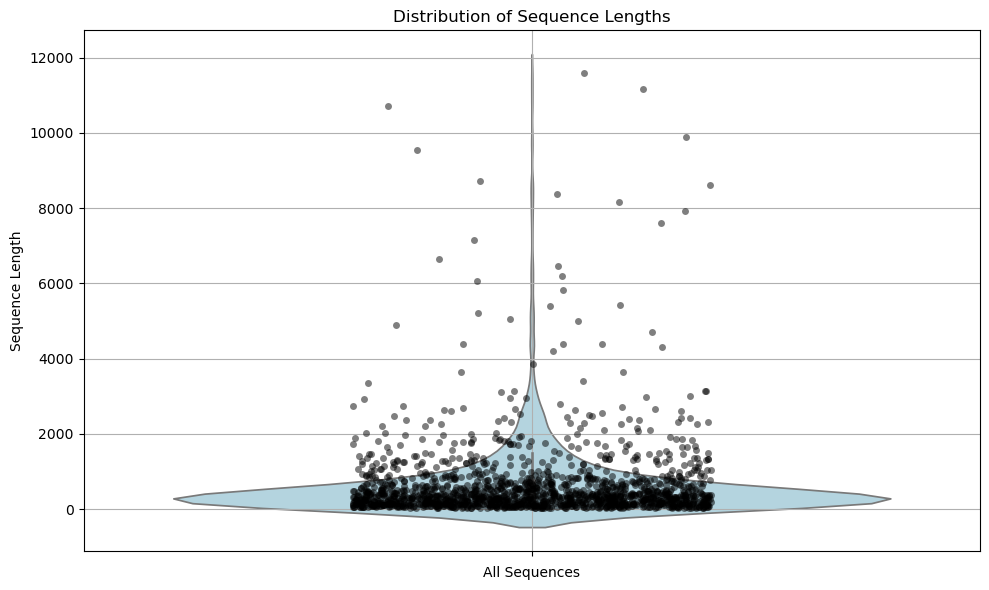

In [5]:
import seaborn as sns

# === Violin plot of sequence lengths with individual dots ===
sequence_lengths = []

for path in onehot_paths:
    try:
        df = pd.read_csv(path)
        sequence_lengths.append(len(df))
    except Exception as e:
        print(f"Error reading {path}: {e}")

# Create the violin plot with overlaid dots
plt.figure(figsize=(10, 6))
sns.violinplot(data=sequence_lengths, inner="box", color="lightblue")
sns.stripplot(data=sequence_lengths, color="black", jitter=0.2, alpha=0.5)

plt.title("Distribution of Sequence Lengths")
plt.xlabel("All Sequences")
plt.ylabel("Sequence Length")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from architectures.hybrid_cnn_transformer import (
    CNNTransformerNet,
    HybridProteinDataset
)
from architectures.cnn_transformer_modules import (
    ImageOnlyDataset,
    SequenceOnlyDataset,
    train_model,
    evaluate_model,
    load_image_sequence_paths,
    get_max_seq_length,
    AA_CODES,
    AA_TO_INDEX,
    NUM_FEATURES
)
import torch

# === Constants ===
csv_dirs = glob.glob("*/onehot_sequences/*.csv")
MAX_SEQ_LENGTH = get_max_seq_length(csv_dirs)

resize_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# === Example Usage ===
if __name__ == "__main__":
    base_dir = "datasets/original_datasets"
    classes = [
        "tumor_antigens_non-immunogenic",
        "tumor_antigens_immunogenic",
        "bacterial_non_antigens",
        "bacterial_antigens"
    ]

    image_paths, onehot_paths, labels = load_image_sequence_paths(base_dir, classes)

    train_img, test_img, train_onehot, test_onehot, train_labels, test_labels = train_test_split(
        image_paths, onehot_paths, labels, test_size=0.2, stratify=labels, random_state=42
    )
    train_img, val_img, train_onehot, val_onehot, train_labels, val_labels = train_test_split(
        train_img, train_onehot, train_labels, test_size=0.1, stratify=train_labels, random_state=42
    )

    train_set = HybridProteinDataset(train_img, train_onehot, train_labels, transform=resize_transform, max_seq_length=MAX_SEQ_LENGTH)
    val_set = HybridProteinDataset(val_img, val_onehot, val_labels, transform=resize_transform, max_seq_length=MAX_SEQ_LENGTH)
    test_set = HybridProteinDataset(test_img, test_onehot, test_labels, transform=resize_transform, max_seq_length=MAX_SEQ_LENGTH)


    train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

    model = CNNTransformerNet(num_classes=4)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, train_accs, val_accs, train_losses, val_losses = train_model(
        model, train_loader, val_loader, num_epochs=10, device=device, model_name="CNNTransformer"
    )


/Users/marcobenavides/miniforge3/envs/ML4FG/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- Starting training for CNNTransformer ---
[CNNTransformer] Epoch 1/10 | Train Acc: 0.3363 | Val Acc: 0.3387 | Train Loss: nan | Val Loss: nan
[CNNTransformer] Epoch 2/10 | Train Acc: 0.3363 | Val Acc: 0.3387 | Train Loss: nan | Val Loss: nan
[CNNTransformer] Epoch 3/10 | Train Acc: 0.3363 | Val Acc: 0.3387 | Train Loss: nan | Val Loss: nan
[CNNTransformer] Epoch 4/10 | Train Acc: 0.3363 | Val Acc: 0.3387 | Train Loss: nan | Val Loss: nan
[CNNTransformer] Epoch 5/10 | Train Acc: 0.3363 | Val Acc: 0.3387 | Train Loss: nan | Val Loss: nan
[CNNTransformer] Epoch 6/10 | Train Acc: 0.3363 | Val Acc: 0.3387 | Train Loss: nan | Val Loss: nan
[CNNTransformer] Epoch 7/10 | Train Acc: 0.3363 | Val Acc: 0.3387 | Train Loss: nan | Val Loss: nan
[CNNTransformer] Epoch 8/10 | Train Acc: 0.3363 | Val Acc: 0.3387 | Train Loss: nan | Val Loss: nan
[CNNTransformer] Epoch 9/10 | Train Acc: 0.3363 | Val Acc: 0.3387 | Train Loss: nan | Val Loss: nan
[CNNTransformer] Epoch 10/10 | Train Acc: 0.3363 | Val


===== Training CNN Backbone =====

--- Starting training for CNN ---
[CNN] Epoch 1/10 | Train Acc: 0.3822 | Val Acc: 0.3548 | Train Loss: 2.9381 | Val Loss: 1.4775
[CNN] Epoch 2/10 | Train Acc: 0.6007 | Val Acc: 0.4839 | Train Loss: 0.9743 | Val Loss: 1.1016
[CNN] Epoch 3/10 | Train Acc: 0.7158 | Val Acc: 0.6210 | Train Loss: 0.7529 | Val Loss: 0.8245
[CNN] Epoch 4/10 | Train Acc: 0.7428 | Val Acc: 0.6774 | Train Loss: 0.6526 | Val Loss: 0.7261
[CNN] Epoch 5/10 | Train Acc: 0.7842 | Val Acc: 0.6613 | Train Loss: 0.5246 | Val Loss: 0.6976
[CNN] Epoch 6/10 | Train Acc: 0.7806 | Val Acc: 0.6774 | Train Loss: 0.5018 | Val Loss: 0.6587
[CNN] Epoch 7/10 | Train Acc: 0.8219 | Val Acc: 0.6935 | Train Loss: 0.4379 | Val Loss: 0.6595
[CNN] Epoch 8/10 | Train Acc: 0.8237 | Val Acc: 0.6371 | Train Loss: 0.4166 | Val Loss: 0.6721
[CNN] Epoch 9/10 | Train Acc: 0.8435 | Val Acc: 0.6613 | Train Loss: 0.3919 | Val Loss: 0.6962
[CNN] Epoch 10/10 | Train Acc: 0.8777 | Val Acc: 0.6452 | Train Loss: 0.347

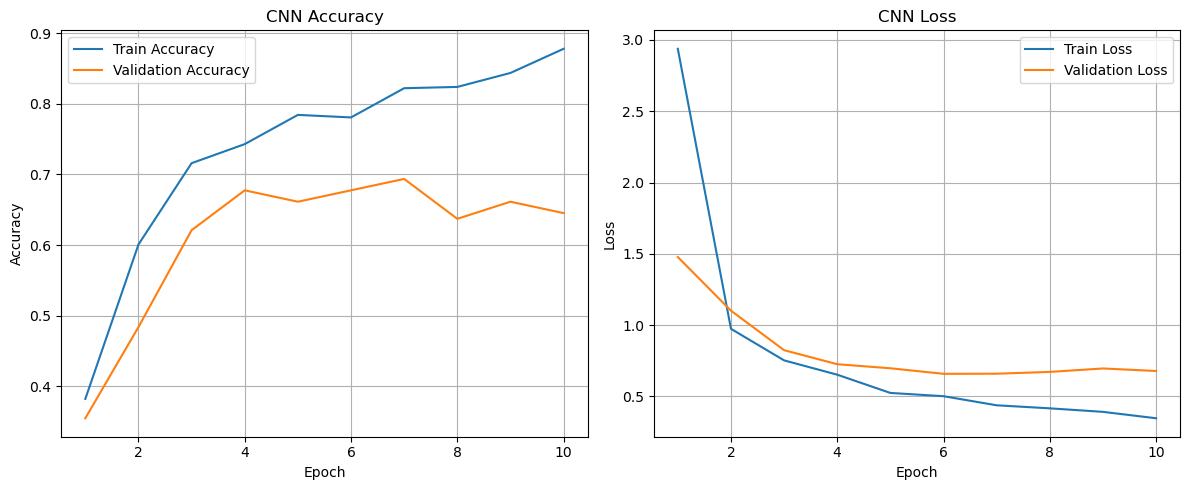

In [ ]:
# === cnn_transformer_split_stage1.py ===
# Train the CNN Backbone Only

# (Reuse model and dataset definitions from above)

import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# Define plotting function

def plot_training_metrics(train_accs, val_accs, train_losses, val_losses, model_name="Model"):
    epochs = range(1, len(train_accs) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, label="Train Accuracy")
    plt.plot(epochs, val_accs, label="Validation Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_metrics.png")
    plt.show()

# Load data

base_dir = "/kaggle/input/dataset"
classes = ["protein_antigens_non-immunogenic", "protein_antigens_immunogenic", "bacterial_non_antigens", "bacterial_antigens"]
image_paths, onehot_paths, labels = load_image_sequence_paths(base_dir, classes)

train_img, test_img, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
train_img, val_img, train_labels, val_labels = train_test_split(
    train_img, train_labels, test_size=0.1, stratify=train_labels, random_state=42)

image_train_set = ImageOnlyDataset(train_img, train_labels, transform=resize_transform)
image_val_set = ImageOnlyDataset(val_img, val_labels, transform=resize_transform)
image_train_loader = DataLoader(image_train_set, batch_size=32, shuffle=True)
image_val_loader = DataLoader(image_val_set, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNNClassifier().to(device)
print("\n===== Training CNN Backbone =====")
cnn_model, train_accs, val_accs, train_losses, val_losses = train_model(cnn_model, image_train_loader, image_val_loader, device=device, model_name="CNN")
print("Final CNN Validation Accuracy:", val_accs[-1])
plot_training_metrics(train_accs, val_accs, train_losses, val_losses, model_name="CNN")
torch.save(cnn_model.cnn.state_dict(), "cnn_backbone.pth")



===== Training Transformer Backbone =====

--- Starting training for Transformer ---
[Transformer] Epoch 1/10 | Train Acc: 0.3543 | Val Acc: 0.3629 | Train Loss: 1.3301 | Val Loss: 1.3080
[Transformer] Epoch 2/10 | Train Acc: 0.4191 | Val Acc: 0.3871 | Train Loss: 1.3120 | Val Loss: 1.2969
[Transformer] Epoch 3/10 | Train Acc: 0.4775 | Val Acc: 0.4274 | Train Loss: 1.2767 | Val Loss: 1.2712
[Transformer] Epoch 4/10 | Train Acc: 0.4973 | Val Acc: 0.4274 | Train Loss: 1.2218 | Val Loss: 1.2677
[Transformer] Epoch 5/10 | Train Acc: 0.5027 | Val Acc: 0.4677 | Train Loss: 1.1976 | Val Loss: 1.2686
[Transformer] Epoch 6/10 | Train Acc: 0.5054 | Val Acc: 0.4113 | Train Loss: 1.1734 | Val Loss: 1.2747
[Transformer] Epoch 7/10 | Train Acc: 0.5018 | Val Acc: 0.4677 | Train Loss: 1.1658 | Val Loss: 1.2605
[Transformer] Epoch 8/10 | Train Acc: 0.4991 | Val Acc: 0.4677 | Train Loss: 1.1667 | Val Loss: 1.2726
[Transformer] Epoch 9/10 | Train Acc: 0.5063 | Val Acc: 0.4677 | Train Loss: 1.1416 | Val 

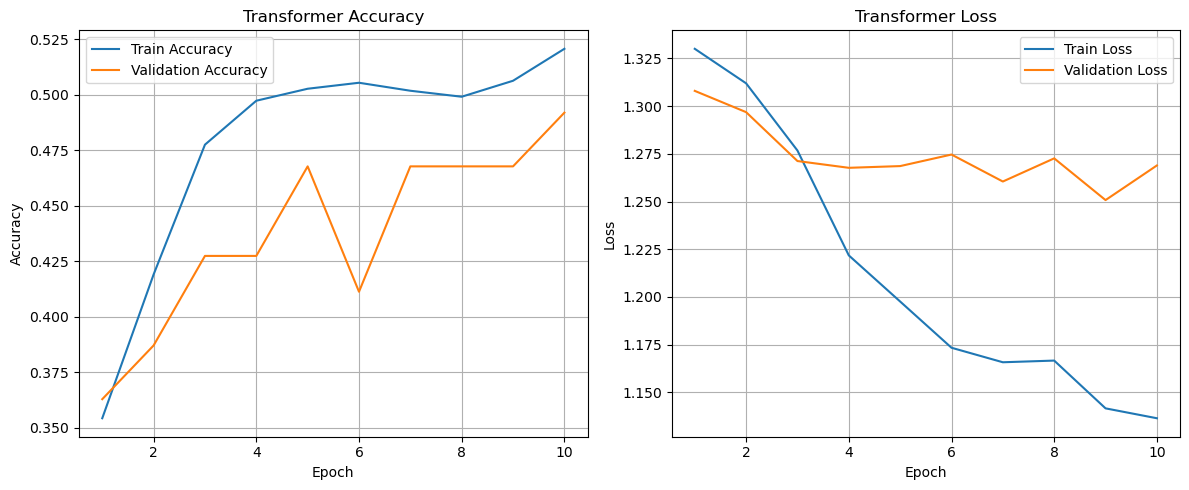

In [ ]:
# === cnn_transformer_split_stage2.py ===

import torch

base_dir = "/kaggle/input/dataset"
classes = ["protein_antigens_non-immunogenic", "protein_antigens_immunogenic", "bacterial_non_antigens", "bacterial_antigens"]
image_paths, onehot_paths, labels = load_image_sequence_paths(base_dir, classes)

# Train the Transformer Backbone Only
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("Using device:", device)
# Load data again
_, onehot_paths, labels = load_image_sequence_paths(base_dir, classes)
# Filter out invalid CSVs before splitting
valid_paths, valid_labels = [], []
for path, label in zip(onehot_paths, labels):
    try:
        df = pd.read_csv(path)
        if df.shape[0] > 0 and df.shape[1] == NUM_FEATURES:
            valid_paths.append(path)
            valid_labels.append(label)
    except Exception:
        continue

# Move this after valid_paths is populated
if not valid_paths:
    raise ValueError("No valid CSV files found. Check file paths and formatting.")
MAX_SEQ_LENGTH = max(len(pd.read_csv(p)) for p in valid_paths)
print("MAX_SEQ_LENGTH:", MAX_SEQ_LENGTH)

# Continue as usual
onehot_paths = valid_paths
labels = valid_labels


train_onehot, test_onehot, train_labels, test_labels = train_test_split(
    onehot_paths, labels, test_size=0.2, stratify=labels, random_state=42)
train_onehot, val_onehot, train_labels, val_labels = train_test_split(
    train_onehot, train_labels, test_size=0.1, stratify=train_labels, random_state=42)

seq_train_set = SequenceOnlyDataset(train_onehot, train_labels)
seq_val_set = SequenceOnlyDataset(val_onehot, val_labels)
seq_train_loader = DataLoader(seq_train_set, batch_size=16, shuffle=True)
seq_val_loader = DataLoader(seq_val_set, batch_size=16, shuffle=False)

seq_model = SequenceClassifier().to(device)
print("\n===== Training Transformer Backbone =====")
seq_model, train_accs, val_accs, train_lossoses, val_losses = train_model(seq_model, seq_train_loader, seq_val_loader, device=device, model_name="Transformer", epochs=30)
print("Final Transformer Validation Accuracy:", val_accs[-1])
plot_training_metrics(train_accs, val_accs, train_losses, val_losses, model_name="Transformer")
torch.save(seq_model.transformer.state_dict(), "transformer_backbone.pth")

In [ ]:
# === cnn_transformer_split_stage3.py ===
# Combine Both Backbones and Fine-tune Classifier

image_paths, onehot_paths, labels = load_image_sequence_paths(base_dir, classes)
train_img, test_img, train_onehot, test_onehot, train_labels, test_labels = train_test_split(
    image_paths, onehot_paths, labels, test_size=0.2, stratify=labels, random_state=42)
train_img, val_img, train_onehot, val_onehot, train_labels, val_labels = train_test_split(
    train_img, train_onehot, train_labels, test_size=0.1, stratify=train_labels, random_state=42)

train_set = HybridProteinDataset(train_img, train_onehot, train_labels, transform=resize_transform)
val_set = HybridProteinDataset(val_img, val_onehot, val_labels, transform=resize_transform)
test_set = HybridProteinDataset(test_img, test_onehot, test_labels, transform=resize_transform)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

model = CNNTransformerNet().to(device)
model.cnn.load_state_dict(torch.load("cnn_backbone.pth"))
model.transformer.load_state_dict(torch.load("transformer_backbone.pth"))

for param in model.cnn.parameters():
    param.requires_grad = False
for param in model.transformer.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
print("MAX_SEQ_LENGTH:", MAX_SEQ_LENGTH)

print("\n===== Fine-tuning Combined CNN + Transformer Model =====")
model, train_accs, val_accs, train_losses, val_losses = train_model(model, train_loader, val_loader, device=device, model_name="Combined")
print("Final Combined Validation Accuracy:", val_accs[-1])
plot_training_metrics(train_accs, val_accs, train_losses, val_losses, model_name="Combined")

def evaluate_combined(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for img, seq, label in loader:
            img, seq = img.to(device), seq.to(device)
            out = model(img, seq)
            preds = out.argmax(1).cpu().numpy()
            y_true.extend(label.numpy())
            y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = evaluate_combined(model, test_loader)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=classes)
plt.show()
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))